In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

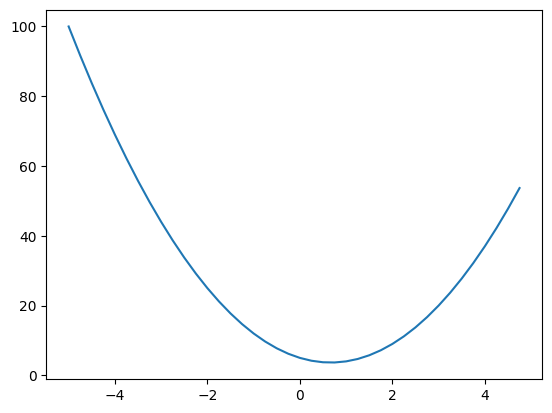

In [5]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 3.0
(f(x+h) - f(x))/h

14.000000305713911

In [7]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)


4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# With respect to a taking the derivative, b should be the slope in this case 3
# in respect to b taking the derivative, a should be the slope in this case 2
d1 = a * b + c
a += h 
d2 = a * b + c

print('d1:', d1)
print('d2:', d2)
print('d2-d1:', d2-d1)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 3.999699999999999
d2-d1: -0.0003000000000010772
slope: -3.000000000010772


In [39]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # repr provides a way of printing a nicer looking expression in python, so we dont just see the memory address
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): #self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # Making sure we are calling _backward from right to left nodes in topological order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [32]:
# Cannot add a constant one
# added an if else for this
a = Value(2.0)
a + 1
# This does not work
# a.__add__(1): This does work
# 1.__add__(a): This does not work
# Fixed using radd which makes it go the other way a.__add__(1)
1 + a

Value(data=3.0)

In [25]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [35]:
# Same
# a / b
# a * (1/b)
# a * (b**-1)
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [36]:
a - b

Value(data=-2.0)

In [42]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

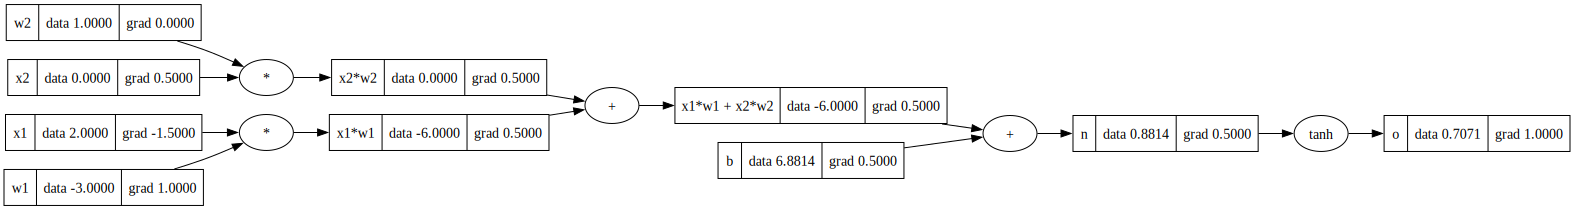

In [44]:
draw_dot(o)

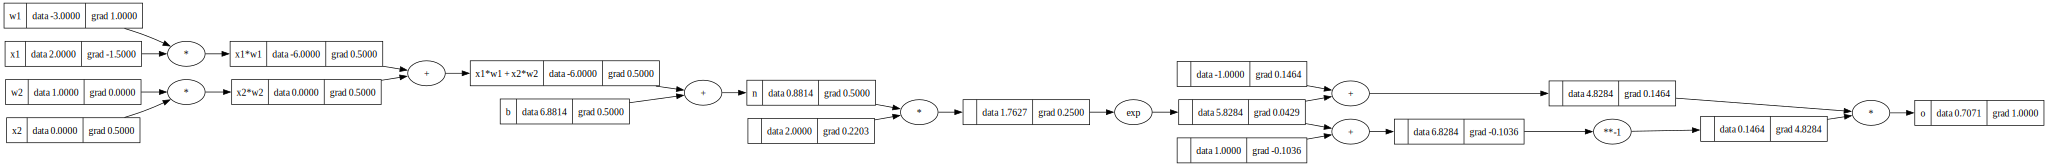

In [45]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----------------
o.label = 'o'
o.backward()
draw_dot(o)

# The level at which we implement our operations is up to us

### Pytorch Implementation

In [46]:
import torch

In [47]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [48]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [52]:
torch.Tensor([2]).dtype # torch.float32
torch.Tensor([2]).double().dtype # torch.float64

torch.float64

In [54]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [61]:
o.item() # same as o.data.item()
x2.grad.item()


0.5000001283844369

### Building Neural Nets

In [68]:
import random

In [111]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    # Forward pass
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
      
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    #params = []
    #for neuron in self.neurons:
    #  ps = neuron.parameters()
    #  params.extend(ps)
    #return params
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [134]:
#x = [2.0, 3.0]
#n = Neuron(2)
#n(x)

#x = [2.0, 3.0]
#n = Layer(2, 3)
#n(x)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.23601997527561464)

In [115]:
len(n.parameters())

41

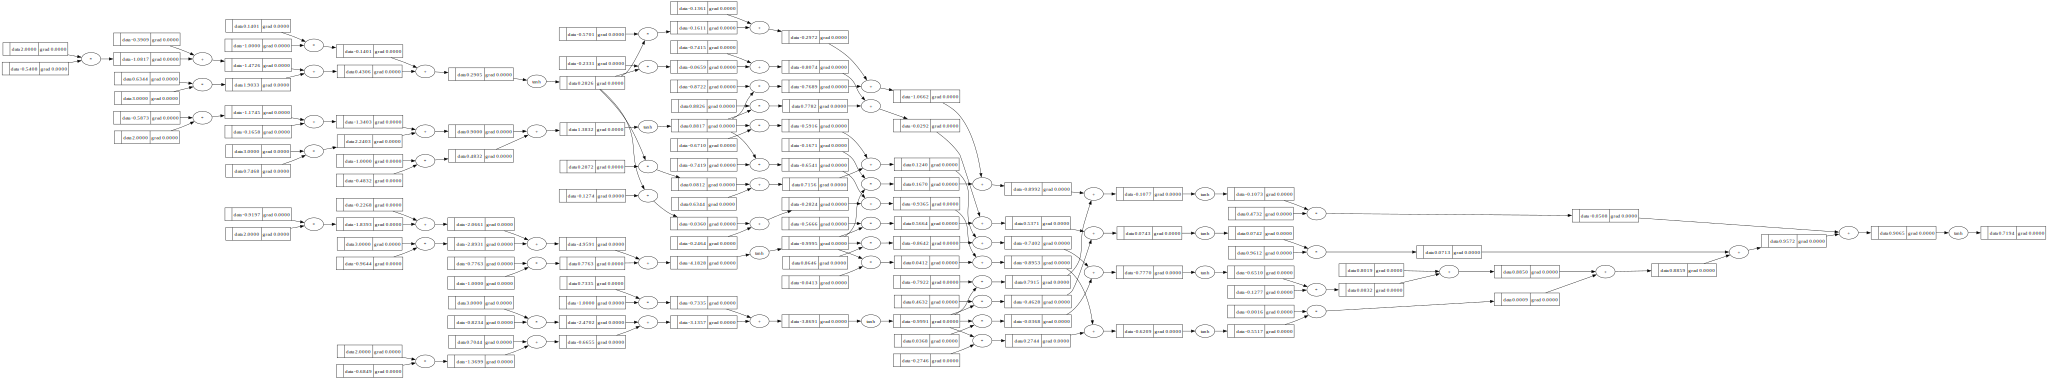

In [116]:
draw_dot(n(x))

In [135]:
# 4 possible inputs, 4 desired targets
xs = [
    [2.0, 3.0, -1.0], # 1
    [3.0, -1.0, 0.5], # -1
    [0.5, 1.0, 1.0], # -1
    [1.0, 1.0, -1.0] # 1
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.23601997527561464),
 Value(data=-0.19045868312430028),
 Value(data=-0.5566357256243442),
 Value(data=-0.0850886020188655)]

### Training automated

In [136]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # Mean Squared Error Loss, Might use a Cross Entropy Loss for predicting next token
    
    # Inital Bug: we forgot to zero_grad() before backward()
    # Important because the gradients never get reset after iteration as they are added up
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()
    
    # update parameters (a very simple stochastic gradient descent update)
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 3.557091677033081
1 2.976076916605434
2 2.7031433202720443
3 2.3329002545312663
4 1.6649249886899602
5 0.9881425944047199
6 0.6496084268809753
7 0.47163440081076285
8 0.3637574198505115
9 0.29236562875955985
10 0.24221892289997898
11 0.2053944579724781
12 0.17739648557471172
13 0.15550524120522996
14 0.13799052269252465
15 0.12370550873372024
16 0.11186350269209747
17 0.1019088649577889
18 0.09343916992224938
19 0.08615652536038597


In [137]:
ypred

[Value(data=0.8312516310448125),
 Value(data=-0.8547788005051349),
 Value(data=-0.8623956582493325),
 Value(data=0.8671227570876489)]

### Manual Training/Tuning

In [118]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.07871770607483511),
 Value(data=2.1946871380224957),
 Value(data=2.2041044226920943),
 Value(data=0.06990027495369854)]

In [119]:
# A single number that we define that measures how well the neural network is performing
# Mean Squared Error Loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.547409541743124)

In [126]:
# New Loss after 1 step of gradient descent
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.990314129924222)

In [120]:
loss.backward()

In [121]:
n.layers[0].neurons[0].w[0].grad
#n.layers[0].neurons[0].w[1].grad
#n.layers[0].neurons[0].w[2].grad
#n.layers[0].neurons[0].b.grad

-0.2628865601314649

In [122]:
n.layers[0].neurons[0].w[0].data

-0.5408489466822028

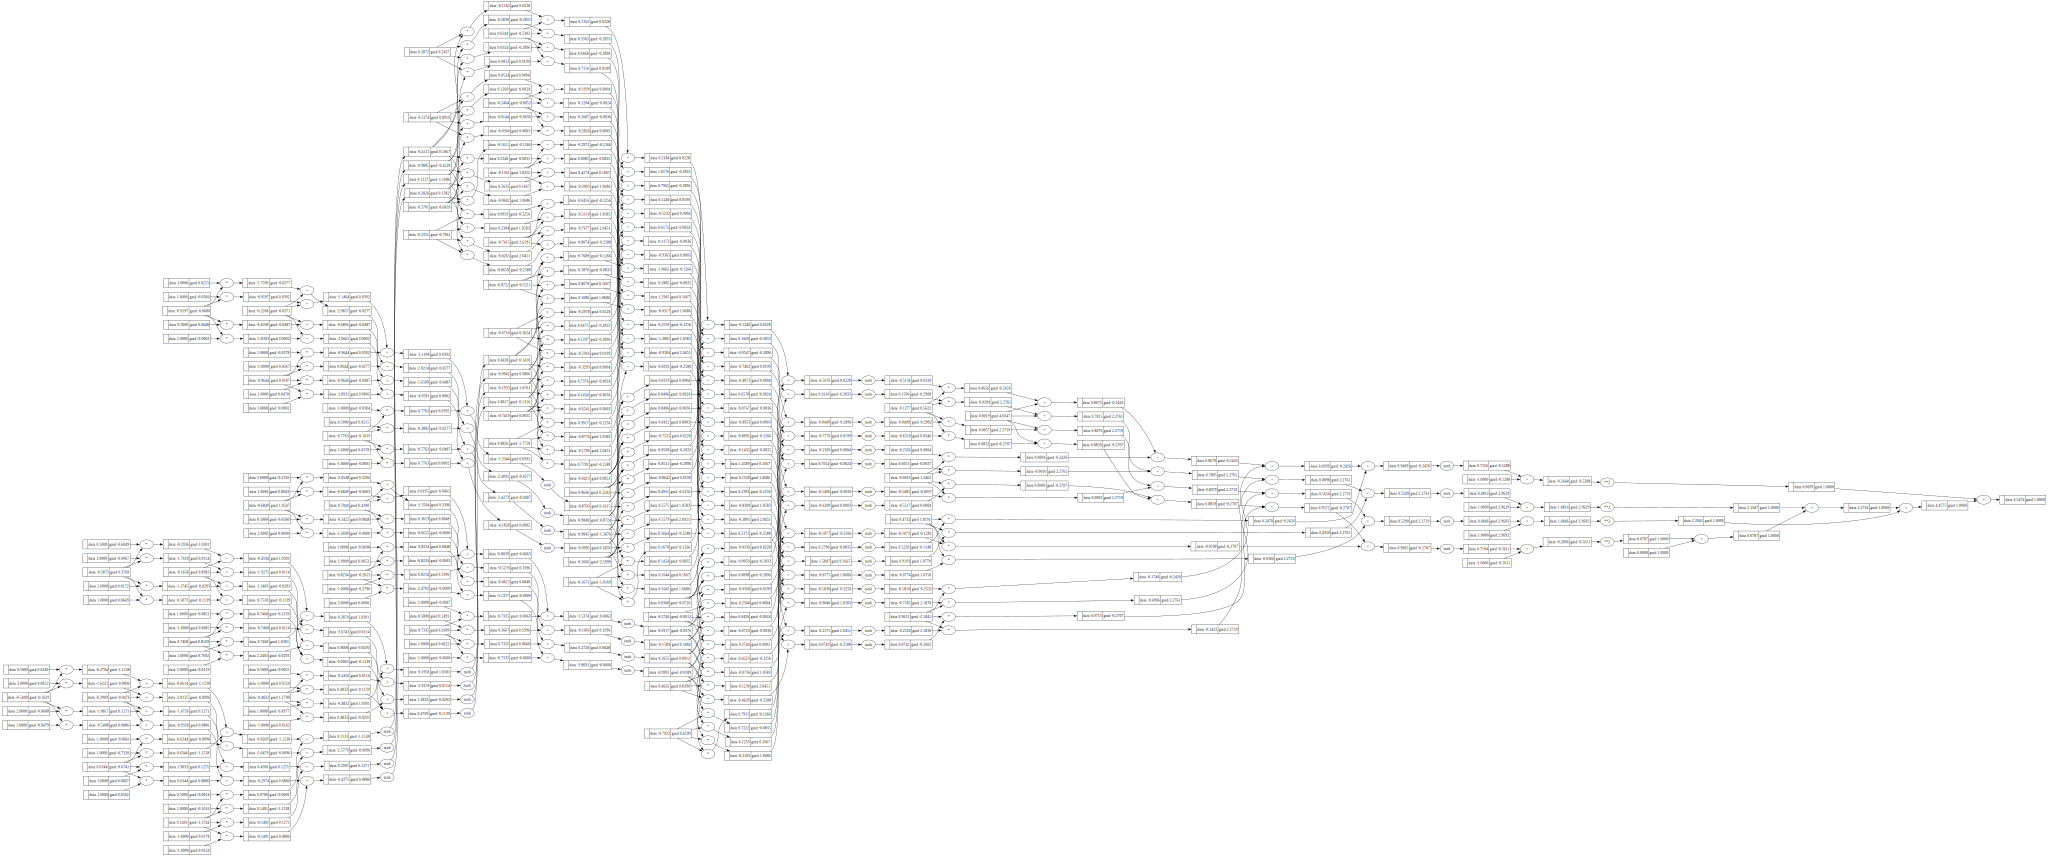

In [123]:
draw_dot(loss)

In [124]:
# gradient descent we are thinking of the gradient as a vector pointing in the direction of increased loss
# modifying p.data by a small step size in the direction of the gradient (learning rate)
# learning rate too low takes a while to converge, too large makes unstable and might explode the loss
for p in n.parameters():
    # negative to minimize the loss; Think of the gradient vector as pointing in the direction of increasing loss, we want to decrease it so we move in the opposite direction
    p.data += -0.01 * p.grad

In [125]:
n.layers[0].neurons[0].w[0].data

-0.5382200810808881

### Summary

What are Neural Nets?

Neural Nets are mathematical equations that take input as the data, and they take input, the weights, and the parameters in the neural net. 

Mathematical expression for the forward pass. 

Followed by a loss function and the loss function tries to measure the accuracy of the predictions.

Usually the loss will be low when your predictions are matching your targets or when the network is behaving well.

We then backward the loss, using backpropogation to get the gradient and then we know how to tune all the parameters to decrease the loss locally.

We then iterate this process many times in whats called the gradient descent.

Which means we follow the gradient information and that minimizes the loss and the loss is arranged so that when the loss is minimized the network is doing what you want it to do.



